This notebook creates a Keras Sequence model that uses Xception as a trained base, freezes it, adds a head and trains it with a dataset of 31,000 299x299 images - half containing smoke and half no smoke. It then saves the model and tests it on some sample images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Make sure that we can connect to a TPU 
# Unfortunately this model cannot be trained on a GPU - it runs out of RAM with 27G of virtual memory very quickly
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.5.0
Running on TPU  ['10.11.174.146:8470']


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [1]:
# Setup
# Imports
import os, warnings
import shutil
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sn
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from keras.models import load_model

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [2]:
# Instantiate a base Xception model with pre-trained weights
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [3]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [7]:
# Freeze the base model
base_model.trainable = False

In [8]:
# Attach the head
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])


In [9]:
# Compile the composite model
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               26214528  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 47,076,137
Trainable params: 26,214,657
Non-trainable params: 20,861,480
_________________________________________________________________


In [10]:
## LOAD THE DATA ##
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    #'train',
    '/content/drive/MyDrive/large',
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset='training',
    seed=1337,
    image_size=[299, 299],
    interpolation='nearest',
    batch_size=32,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    #'valid',
    '/content/drive/MyDrive/large',
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=[299, 299],
    interpolation='nearest',
    batch_size=32,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)



Found 31310 files belonging to 2 classes.
Using 25048 files for training.
Found 31310 files belonging to 2 classes.
Using 6262 files for validation.


In [11]:
# Train the model on new data - the nosmoke and smoke image datasets
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=12,
    verbose=2,
)

Epoch 1/12
783/783 - 857s - loss: 0.2504 - binary_accuracy: 0.8912 - val_loss: 0.1958 - val_binary_accuracy: 0.9203
Epoch 2/12
783/783 - 1181s - loss: 0.1164 - binary_accuracy: 0.9540 - val_loss: 0.1246 - val_binary_accuracy: 0.9497
Epoch 3/12
783/783 - 1263s - loss: 0.0839 - binary_accuracy: 0.9682 - val_loss: 0.2223 - val_binary_accuracy: 0.9115
Epoch 4/12
783/783 - 1245s - loss: 0.0715 - binary_accuracy: 0.9727 - val_loss: 0.4010 - val_binary_accuracy: 0.8346
Epoch 5/12
783/783 - 1276s - loss: 0.0512 - binary_accuracy: 0.9808 - val_loss: 0.1910 - val_binary_accuracy: 0.9195
Epoch 6/12
783/783 - 1276s - loss: 0.0328 - binary_accuracy: 0.9885 - val_loss: 0.0072 - val_binary_accuracy: 0.9989
Epoch 7/12
783/783 - 1275s - loss: 0.0237 - binary_accuracy: 0.9919 - val_loss: 0.0063 - val_binary_accuracy: 0.9990
Epoch 8/12
783/783 - 1276s - loss: 0.0241 - binary_accuracy: 0.9912 - val_loss: 0.0539 - val_binary_accuracy: 0.9791
Epoch 9/12
783/783 - 1287s - loss: 0.0307 - binary_accuracy: 0.98

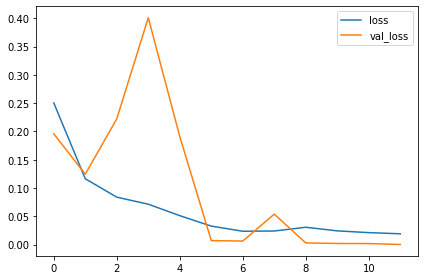

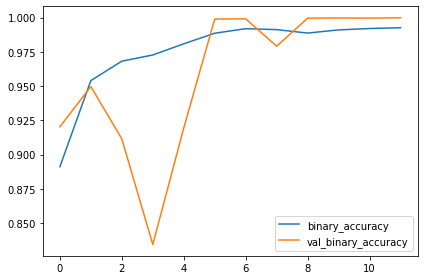

In [12]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [13]:
# Save our trained model
model.save('/content/drive/MyDrive/Streamline1')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Streamline1/assets


In [14]:
reloaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Streamline1')
# reloaded_model = tf.keras.models.load_model('TinyXception')

In [15]:
# Calculate Confusion Matrix based on running predictions against the entire input dataset
def getMyPrediction(name,model):
    image = keras.preprocessing.image.load_img(
    name, target_size=(299,299)   
)
    # Replace the line below with the line above.....to guard against images with incorrect image sizes
    #image = tf.keras.preprocessing.image.load_img(name)
    input_arr = keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch. 
    # Note: Xception expects a specific kind of input processing.
    # Before passing inputs to the model, call tf.keras.applications.xception.preprocess_input. 
    # It will scale scale input pixels between -1 and 1.
    x = preprocess_input(input_arr)
    predictions = model.predict(x)
    return(predictions[0][0])

# Initialize variables
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0
total_predictions = 0
y_Actual = []
y_Predicted = []

smoke_directory = r'/content/drive/MyDrive/large/smoke' # dataset of images containing smoke 
nosmoke_directory = r'/content/drive/MyDrive/large/nosmoke' # dataset of images containing no smoke 
#smoke_directory = r'C:\Users\mthor\Unsynced Documents\LargeSmoke' # dataset of images containing smoke 
#nosmoke_directory = r'C:\Users\mthor\Unsynced Documents\LargeNonSmoke' # dataset of images containing no smoke 
# NOTE: make sure these directories are empty before running this cell
false_neg_directory = r'/content/drive/MyDrive/falsenegatives'
false_pos_directory = r'/content/drive/MyDrive/falsepositives'

# go through the smoke dataset getting predictions for each image & updating counts
# if it's a false negative then copy the image to the false negatives directory

nosmoke = 0
smoke = 1

for filename in os.listdir(smoke_directory):
    if filename.endswith(".jpg"):
        name = os.path.join(smoke_directory, filename)
        prediction = getMyPrediction(name,reloaded_model)
        total_predictions = total_predictions + 1
        y_Actual.append(smoke)
        
                   
        if prediction > 0.5:
            predicted = 'smoke'
            y_Predicted.append(smoke)
            true_positives = true_positives + 1
        else:
            if prediction <= 0.5:
                predicted = 'nosmoke'
                y_Predicted.append(nosmoke)
                false_negatives = false_negatives + 1
                targetfilepath = os.path.join(false_neg_directory, filename)
                shutil.copyfile(name,targetfilepath)
    
                
    else:
        continue

print(' True positives:', true_positives, ' False negatives:', false_negatives) 

# go through the nosmoke dataset getting predictions for each image & updating counts
# if it's a false positive then copy the image to the false positives directory

for filename in os.listdir(nosmoke_directory):
    if filename.endswith(".jpg"):
        name = os.path.join(nosmoke_directory, filename)
        prediction = getMyPrediction(name,model)
        total_predictions = total_predictions + 1
        y_Actual.append(nosmoke)
                   
        if prediction > 0.5:
            predicted = 'smoke'
            false_positives = false_positives + 1
            y_Predicted.append(smoke)
            targetfilepath = os.path.join(false_pos_directory, filename)
            shutil.copyfile(name,targetfilepath)
        else:
            if prediction <= 0.5:
                predicted = 'nosmoke'
                y_Predicted.append(nosmoke)
                true_negatives = true_negatives + 1
               
                
    else:
        continue
        
 
false_pos_pct = round((false_positives/total_predictions * 100),2)
false_neg_pct = round((false_negatives/total_predictions * 100),2)
true_pos_pct = round((true_positives/total_predictions * 100),2)
true_neg_pct = round((true_negatives/total_predictions * 100),2)
actual_accuracy = round((((true_positives + true_negatives)/total_predictions)*100),2)

print('Total predictions:', total_predictions, ' False positives:', false_positives, ' True negatives:', true_negatives)
print('False positives %',false_pos_pct,'\n','False negatives %',false_neg_pct, '\n','True positives %',true_pos_pct, '\n','True negatives %',true_neg_pct, '\n','Actual Accuracy %', actual_accuracy)



 True positives: 15538  False negatives: 117
Total predictions: 31310  False positives: 1555  True negatives: 14100
False positives % 4.97 
 False negatives % 0.37 
 True positives % 49.63 
 True negatives % 45.03 
 Actual Accuracy % 94.66


Predicted      0      1
Actual                 
0          14100   1555
1            117  15538


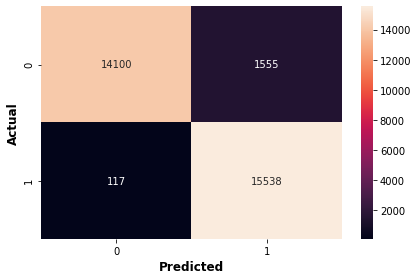

In [22]:
# Visualize confusion matrix
data = {'y_Actual':  y_Actual,
        'y_Predicted': y_Predicted
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
sn.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

In [17]:
df.head()

,y_Actual,y_Predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


     |████████████████████████████████| 798kB 5.3MB/s 


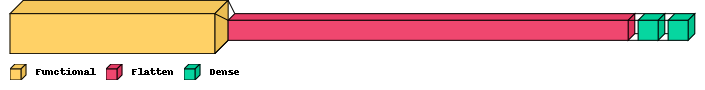

In [19]:
!pip install visualkeras
import visualkeras

model = reloaded_model

# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png', legend=True).show() # write and show

visualkeras.layered_view(reloaded_model, legend=True)

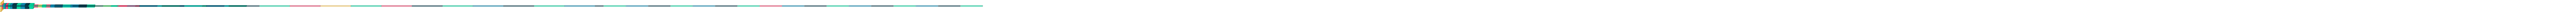

In [18]:
#!pip install visualkeras
#import visualkeras

#model = base_model

# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='output.png') # write to disk
# visualkeras.layered_view(base_model, to_file='XceptionFlat.png', draw_volume=False, legend=False).show() # write and show
#visualkeras.layered_view(base_model, type_ignore=[Flatten], Legend=False, to_file='XceptionSimplified.png')
#visualkeras.layered_view(base_model, legend=True)

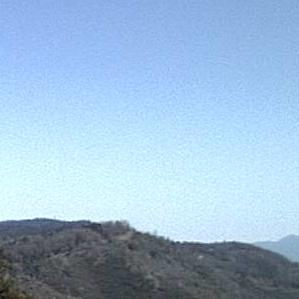

The image contains no smoke.
0.0036920607


In [20]:
# Manual "eyeball check" using 1-12 test images
#from tensorflow import keras
#from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.xception import preprocess_input

# specify the image to be displayed and classified
image_path = '/content/drive/MyDrive/SmokeNoSmoke2.jpg'
# image_path = 'SmokeNoSmoke11.jpg'
image_size = (299,299)
from PIL import Image
import cv2 
from IPython.display import display

img = cv2.imread(image_path) # with the OpenCV function imread(), the order of colors is BGR (blue, green, red).
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB for Pillow
display(Image.fromarray(img))

image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = keras.preprocessing.image.img_to_array(image)
#print('first input array:',input_arr)
input_arr = np.array([input_arr])  # Convert single image to a batch.
#print('second input array:',input_arr)
x = preprocess_input(input_arr)
#print('x is:',input_arr)
predictions = reloaded_model.predict(x)

if predictions[0][0] <= 0.5:
    print("The image contains no smoke.")

if predictions[0][0] > 0.5:
    print("The image contains smoke.")

print(predictions[0][0])


Note: each Keras Application expects a specific kind of input preprocessing. 
For Xception, call tf.keras.applications.xception.preprocess_input on your inputs before passing them to the model.
xception.preprocess_input will scale input pixels between -1 and 1.

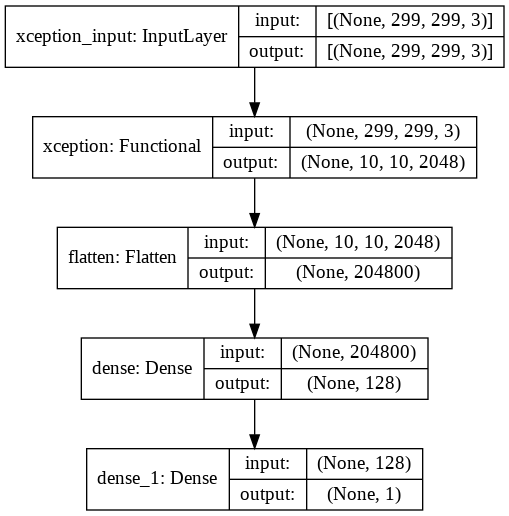

In [21]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(reloaded_model, to_file=dot_img_file, show_shapes=True, show_layer_names=True)